In [82]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import csv

class Struct:
    pass

## Define a classe do Problema (MyProblem) e a classe que tem as funções do VNS (MyVNS)

In [83]:
class MyRVNS:
    def shake(self, x, k, probdata):
        # o objetivo do shake é escolher uma solução aleatoria da k-esima estrutura de vizinhança
        
        y = copy.deepcopy(x)

        ridx1 = np.random.randint(0, probdata.n)
        ridx2 = np.random.randint(0, probdata.n)
        ridx3 = np.random.randint(0, probdata.n)
        
        # trocar as manutenções de lugar não afeta o custo o objetivo
        if k == 1:             # troca o plano de manutenção de uma maquina aleatoria por um mais barato
            y.solution[ridx1] = x.solution[ridx1] - 1 if x.solution[ridx1] > 0 else x.solution[ridx1]
        elif k == 2:           # de duas aleatorias
            y.solution[ridx1] = x.solution[ridx1] - 1 if x.solution[ridx1] > 0 else x.solution[ridx1]
            y.solution[ridx2] = x.solution[ridx2] - 1 if x.solution[ridx2] > 0 else x.solution[ridx2]
        elif k == 3:           # de três aleatorias
            y.solution[ridx1] = x.solution[ridx1] - 1 if x.solution[ridx1] > 0 else x.solution[ridx1]
            y.solution[ridx2] = x.solution[ridx2] - 1 if x.solution[ridx2] > 0 else x.solution[ridx2]
            y.solution[ridx3] = x.solution[ridx3] - 1 if x.solution[ridx3] > 0 else x.solution[ridx3]
        
        return y

    def neighborhoodChange(self, x, y, k):
        # toma a decisao de mudar de vizinhança, comparando a solução imcubente x com a solução do shake y
        
        if y.fitness < x.fitness:
            x = copy.deepcopy(y)
            k = 1
        else:
            k += 1
            
        return x, k
    
class MyVNS:
    def shake(self, x, k, probdata):
        # o objetivo do shake é escolher uma solução aleatoria da k-esima estrutura de vizinhança
        
        y = copy.deepcopy(x)

        ridx1 = np.random.randint(0, probdata.n)
        ridx2 = np.random.randint(0, probdata.n)

        blockSize=50
        startIndex = np.random.randint(0, probdata.n - blockSize)
        blockIndices = range(startIndex, startIndex + blockSize)
        
        if k == 1:             # troca o plano por um diferente movimento 1-swap
            y.solution[ridx1] = np.random.choice([j for j in [0, 1, 2] if j != x.solution[ridx1]])
        elif k == 2:           # permutaçao de dois planos de manutenção em duas máquinas diferentes
            y.solution[ridx1], y.solution[ridx2] = x.solution[ridx2], x.solution[ridx1]
        elif k == 3:           # Mudança de um bloco de máquinas para outro plano (sair de mínimo local)
            # Pega o plano mais comum no bloco e muda para outro
            currentPlans = [x.solution[i] for i in blockIndices]
            currentPlan = max(set(currentPlans), key=currentPlans.count,)
            newPlan = np.random.choice([j for j in [0, 1, 2] if j != currentPlan])
            
            for i in blockIndices:
                y.solution[i] = newPlan

        return y

    def neighborhoodChange(self, x, y, k):
        # toma a decisao de mudar de vizinhança, comparando a solução imcubente x com a solução do shake y
        if y.fitness < x.fitness:
            x = copy.deepcopy(y)
            k = 1
        else:
            k += 1
            
        return x, k
    
    def firstImprovement(self, x, probdata, fobj, k):
        x_linha = copy.deepcopy(x)
        i = 0

        # preciso gerar um conjunto de pontos vizinhos da k-esima estrutura de vizinha
        # usa tamanho 100 na estrutura por enquanto
        neighborhood_size = 100
        neighbors_list = []

        for j in range(neighborhood_size):
            current_x = self.shake(x, k, probdata)
            neighbors_list.append(current_x)

        while True:
            x_neighbor = neighbors_list[i]

            sol_x = fobj(x, probdata)
            sol_neighbor = fobj(x_neighbor, probdata)

            if sol_x.fitness < sol_neighbor.fitness:
                x = sol_x
            else:
                x = sol_neighbor

            i += 1

            if i == neighborhood_size or fobj(x, probdata).fitness < fobj(x_linha, probdata).fitness:
                break

        return x        
    

In [100]:
class MyProblem:
    def fobj1(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina
        # é só somar o vetor que temos a solução
        fitness = np.sum(x.solution)
        
        x.fitness = fitness
        # print(fitness)
        return x
    
    def fobj2(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina, também é o indice j de dipij
        # é só somar o os valores de dipij variando o valor de j
        fitness=0
        for i in range(0,probdata.n):
            j=x.solution[i]
            fitness = fitness + probdata.dipij[i,j]
        
        x.fitness = fitness
        # print(fitness)
        return x


    def sol_inicial(self, probdata, apply_constructive_heuristic):
    
        '''  
        Modelou-se uma solução x como a sequência de manutenções atribuídas em um vetor. exemplo
        
            m1 m2 ... m500
        x = [2 0 ... 1]

            nesse exemplo, a maquina m1 executa a manutenção que tem custo 2, a maquina 2 manutenção que tem custo 1, ...
        '''
        
        if apply_constructive_heuristic == False:        
            # Constrói solução inicial aleatoriamente
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
        
        else:
            # Constrói solução inicial usando uma heurística construtiva
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
            for i in range(probdata.n):        
                var = np.var(probdata.dipij[i,:]) 
                if var>0.5:
                    x.solution[i]=2
                else:
                    x.solution[i]=0
            print(x.solution)
        return x
    
    
    def probF(self,eta,beta,t):
        return (1-np.exp(-(t/eta)**(beta)))
    
    def probdef(self):
        n = 500 # numero de equipamentos

        # extrai os dados do CSV e salva na matriz
        equip_db = np.zeros(shape=(n, 4))

        with open('arquivos_tc/EquipDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                equip_db[idx] = np.array(data_array)

        # agora le o arquivo mpdb
        mpdb = np.zeros(shape=(3, 3))
    	
        # custos do problema sao a ultima coluna do mpdb
        c = np.zeros(3)

        with open('arquivos_tc/MPDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                mpdb[idx] = np.array(data_array)
                c[idx] = data_array[len(data_array) - 1]

        # agora le o arquivo cluster
        cluster = np.zeros(shape=(4, 3))
    	
        with open('arquivos_tc/ClusterDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                cluster[idx] = np.array(data_array)
        
        # geração da matriz dipij, cada linha é uma máquina i e cada coluna o dipij do plano de manutenção j
        dipij = np.zeros(shape=(n, 3))

        for i in range(0,n):
            clusterid=int(equip_db[i,2]-1)
            eta=cluster[clusterid,1]
            beta=cluster[clusterid,2]
            t0=equip_db[i,1]
            di=equip_db[i,3]
            
            for j in range(0,3):
                k=mpdb[j,1]
                Ft0=self.probF(eta,beta,t0)
                Ft0kt=self.probF(eta,beta,(t0+k*5))
                dipij[i,j]= di*(Ft0kt-Ft0)/(1-Ft0)
                # print(f"i={i}  j={j}  k={k}  eta={eta}  beta={beta}  t0={t0}  Ft0={Ft0}  Ft0kt={Ft0kt}  pij={(Ft0kt-Ft0)/(1-Ft0)}")
        
        probdata = Struct()
        probdata.equip_db = equip_db
        probdata.mpdb = mpdb
        probdata.c = c
        probdata.n = n
        probdata.dipij =dipij
            
        return probdata

# Loop principal começa aqui

[0 2 2 0 0 0 2 0 2 0 0 2 0 2 0 2 0 0 0 2 2 2 2 0 0 2 0 2 2 0 0 0 2 0 2 2 0
 0 0 0 2 0 0 0 2 2 0 0 2 2 0 0 0 0 0 0 2 2 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 2 2 0 2 0 2 0 0 2 2 2 2 0 0 0 0 0 0 2 0 0
 0 0 0 2 0 0 0 0 2 2 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 0 2 2 2 2
 2 0 0 0 2 0 0 0 0 0 2 2 0 0 2 0 2 2 0 0 2 0 0 0 0 2 0 0 2 0 2 0 0 0 2 0 2
 2 0 2 0 0 0 0 0 0 2 0 0 0 2 2 0 2 0 2 0 0 0 2 2 2 0 0 2 0 0 0 0 0 2 0 0 0
 2 0 0 0 0 2 2 2 0 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 2 0 2 2 0 0
 0 2 2 0 0 0 2 0 2 0 0 2 0 0 2 0 2 0 0 0 2 0 0 0 2 0 0 2 2 0 2 2 0 2 0 0 0
 2 0 0 0 0 0 0 2 2 0 0 2 0 2 0 0 2 0 0 0 0 2 0 2 0 2 2 2 0 2 2 0 0 2 0 0 2
 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 2 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 2
 2 0 0 0 0 0 2 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2
 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 2 0 0 2 0 2 0 0 0 0
 2 0 2 0 0 0 2 2 0 0 0 0 0 2 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 2 0
 0 2 2 0 2 2 2 0 0 2 2 0 

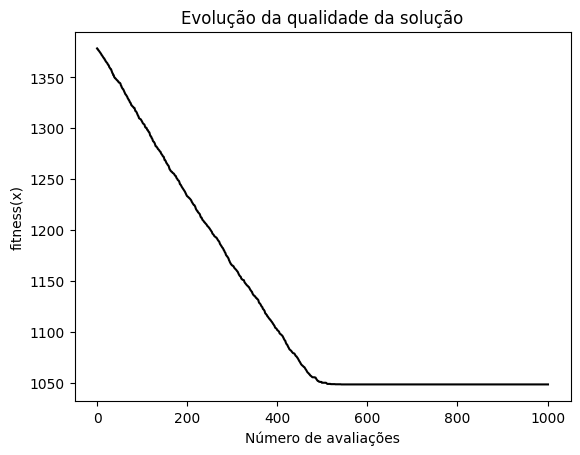

In [104]:
myProblem = MyProblem()
myRVNS = MyRVNS()
myVNS = MyVNS()

num_sol_avaliadas = 0
max_num_sol_avaliadas = 1000
kmax = 3 # Número de estruturas de vizinhanças definidas

# salva os dados do problema 
probdata = myProblem.probdef()

# gera uma solução inicial aleatória
x = myProblem.sol_inicial(probdata, apply_constructive_heuristic=True)

# Avalia solução inicial
#x = myProblem.fobj1(x, probdata)
x = myProblem.fobj2(x, probdata)
num_sol_avaliadas += 1

# agora é definir os shake e vizinhanças do VNS para ele achar a solução ótima

# Armazena dados para plot
historico = Struct()
historico.sol = []
historico.fit = []
historico.sol.append(x.solution)
historico.fit.append(x.fitness)

aux_print = 0

# Ciclo iterativo do método
while num_sol_avaliadas < max_num_sol_avaliadas:
    aux_print += 1

    if aux_print > 100:
        print(num_sol_avaliadas)
        aux_print= 0
    
    k = 1
    while k <= kmax:
        
        # Gera uma solução candidata na k-ésima vizinhança de x        
        y = myVNS.shake(x,k,probdata)

        # faz uma busca local a partir da solução candidata do shake
        y_local = myVNS.firstImprovement(x,probdata, myProblem.fobj2, k)

        #y = myProblem.fobj1(y,probdata)
        y = myProblem.fobj2(y,probdata)
        num_sol_avaliadas += 1
        
        # Atualiza solução corrente e estrutura de vizinhança (se necessário)
        x,k = myVNS.neighborhoodChange(x,y_local,k)
        
        # Armazena dados para plot
        historico.sol.append(x.solution)
        historico.fit.append(x.fitness)


print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
print('Manutenções atribuídas às máquinas:\n')
print('x = {}\n'.format(x.solution))
print('fitness(x) = {:.1f}\n'.format(x.fitness))

plt.figure()
s = len(historico.fit)
plt.plot(np.linspace(0,s-1,s),historico.fit,'k-')
plt.title('Evolução da qualidade da solução');
plt.xlabel('Número de avaliações');
plt.ylabel('fitness(x)');
plt.show()